<a href="https://colab.research.google.com/github/gaikwadadi/Aditya_Gaikwad_NLP_Task/blob/main/Aditya_Gaikwad_NLP_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Importing Essential Libraries

# --- System & Serialization ---
import os        # For file/directory operations
import pickle    # For saving/loading Python objects

# --- Numerical & Data Handling ---
import numpy as np               # For numerical computations
import pandas as pd              # For data manipulation and analysis
import re                        # For regular expressions (text processing)
import warnings
warnings.filterwarnings('ignore') # To avoid the warnigns
from sklearn.utils import class_weight


# --- Visualization ---
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For advanced visualizations

# --- TensorFlow & Keras (Deep Learning) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential                           # For building sequential models
from tensorflow.keras.layers import (                                    # Common neural network layers
    Embedding, Bidirectional, GRU, LSTM, Dense, Dropout, LayerNormalization
)
from tensorflow.keras.regularizers import l2                            # For L2 regularization
from tensorflow.keras.optimizers import Adam                            # Optimizer
from tensorflow.keras.callbacks import (                                # Training callbacks
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.preprocessing.text import Tokenizer               # Tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences       # For padding sequences

# --- Scikit-Learn (Classical ML Utilities) ---
from sklearn.preprocessing import LabelEncoder                          # For encoding categorical labels
from sklearn.model_selection import train_test_split, StratifiedKFold   # For train-test splits and cross-validation
from sklearn.utils.class_weight import compute_class_weight             # For handling class imbalance
from sklearn.metrics import (                                           # For model evaluation
    confusion_matrix, classification_report, f1_score
)

In [8]:
# Download GloVe embeddings if not present

if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    os.system('wget -nc http://nlp.stanford.edu/data/glove.6B.zip')
    os.system('unzip -o glove.6B.zip')

glove_path = './glove.6B.100d.txt'
embedding_dim = 100

#Task 1. Educational Text Classification Model

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.4672 - loss: 1.8017 - val_accuracy: 0.9643 - val_loss: 0.3838 - learning_rate: 3.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9547 - loss: 0.3798 - val_accuracy: 0.9961 - val_loss: 0.1131 - learning_rate: 3.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9894 - loss: 0.1459 - val_accuracy: 0.9986 - val_loss: 0.0605 - learning_rate: 3.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9960 - loss: 0.0851 - val_accuracy: 0.9984 - val_loss: 0.0437 - learning_rate: 3.0000e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9968 - loss: 0.0624 - val_accuracy: 0.9995 - val_loss: 0.0327 - learning_rate: 3.0000e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9984 - loss: 0.0473 - val_accuracy: 0.9999 - val_loss: 0.0251 - learning_rate: 3.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━

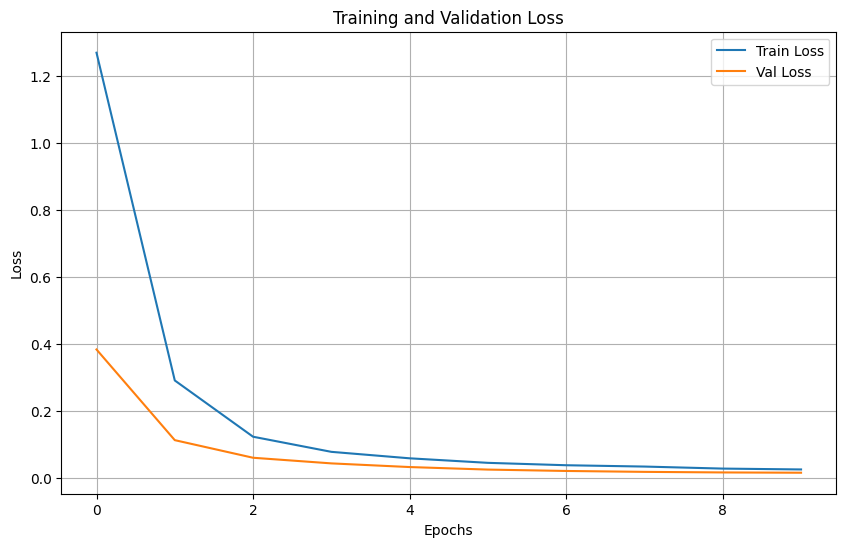

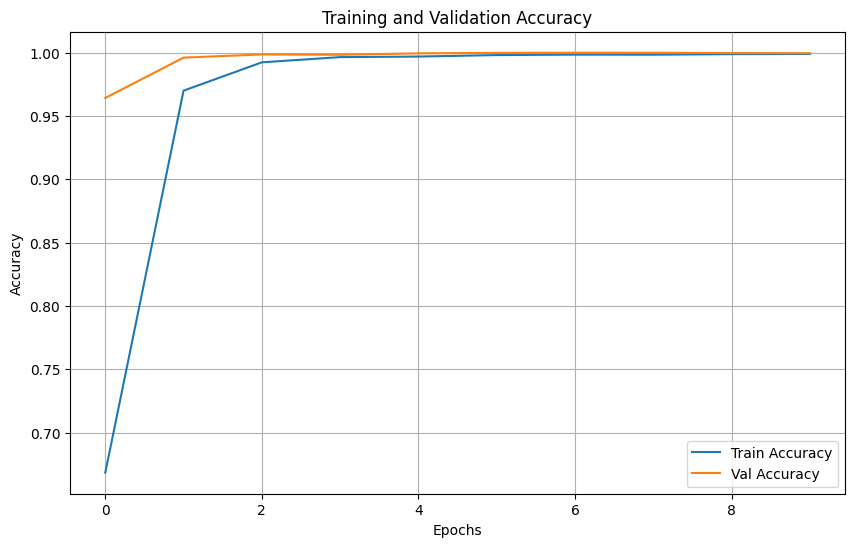


Test Accuracy: 0.9998
Test Loss: 0.0162
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


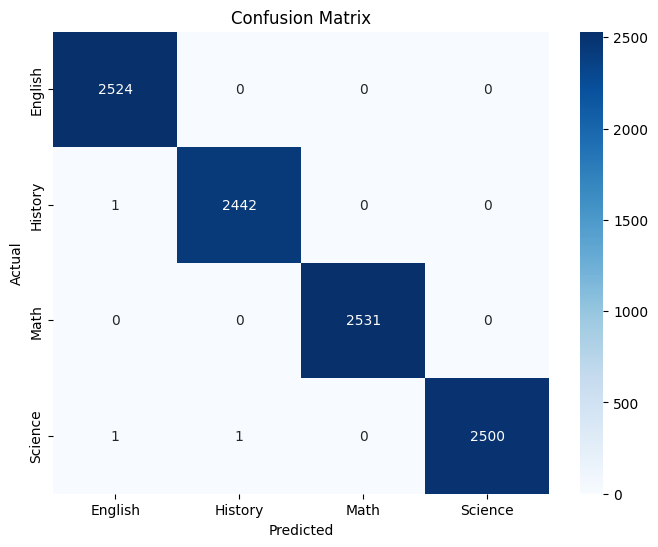


Classification Report:
              precision    recall  f1-score   support

     English       1.00      1.00      1.00      2524
     History       1.00      1.00      1.00      2443
        Math       1.00      1.00      1.00      2531
     Science       1.00      1.00      1.00      2502

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

F1 Score (weighted): 0.9997


In [32]:
# Load dataset
classification_df = pd.read_csv('/content/educational_text_classification_50k.csv')
texts = classification_df[classification_df.columns[0]].values
labels = classification_df['Category'].values

# Label encoding
le = LabelEncoder()
y = le.fit_transform(labels)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Tokenize texts
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Load GloVe embeddings into embedding matrix
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)


# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Prepare one fold for validation using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(X_train, y_train))

X_tr, X_val = X_train[train_idx], X_train[val_idx]
y_tr, y_val = y_train[train_idx], y_train[val_idx]


# Define model architecture
def create_model():
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1,
                  output_dim=embedding_dim,
                  input_length=max_len,
                  weights=[embedding_matrix],
                  trainable=False,
                  embeddings_regularizer=l2(1e-4)),
        Bidirectional(GRU(32, return_sequences=True, dropout=0.5, recurrent_dropout=0)),
        LayerNormalization(),
        Bidirectional(GRU(16, dropout=0.5, recurrent_dropout=0)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
        Dropout(0.3),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()


# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Train the model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    shuffle=True
)


# Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


# Predictions and Confusion Matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print(f"F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")


### Model Testing Using Text

In [45]:
def predict_categories(texts, model, tokenizer, label_encoder, max_len, return_confidence=False, threshold=None):
    """
    Predict categories for a list of input texts using a trained model.

    Args:
        texts (list of str): Input educational texts.
        model (keras.Model): Trained classification model.
        tokenizer (Tokenizer): Tokenizer used during training.
        label_encoder (LabelEncoder): Label encoder used during training.
        max_len (int): Max sequence length used during training.
        return_confidence (bool): Whether to return confidence scores.
        threshold (float): Optional confidence threshold to flag uncertain predictions.

    Returns:
        List of tuples: (text, predicted_label[, confidence])
    """
    if not texts or not isinstance(texts, list):
        raise ValueError("Input must be a non-empty list of text strings.")

    # Tokenize and pad sequences
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Predict probabilities
    predictions = model.predict(padded_sequences, verbose=0)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    confidence_scores = np.max(predictions, axis=1)

    results = []
    for text, label, confidence in zip(texts, predicted_labels, confidence_scores):
        if threshold is not None and confidence < threshold:
            label = "Uncertain"
        if return_confidence:
            results.append((text, label, float(confidence)))
        else:
            results.append((text, label))
    return results


In [46]:
 # Real-world educational test samples
test_samples = [
    "Solve the quadratic equation using the quadratic formula.",
    "Explain the significance of the American Revolution.",
    "Describe the process of photosynthesis in plants.",
    "What are the rules of subject-verb agreement in English grammar?",
    "The French Revolution began in 1789 and led to the rise of Napoleon Bonaparte and the decline of monarchies across Europe."
]

# Predict and display
results = predict_categories(test_samples, model, tokenizer, le, max_len)
for text, label in results:
    print(f"\nText: {text}\nPredicted Subject: {label}")



Text: Solve the quadratic equation using the quadratic formula.
Predicted Subject: Math

Text: Explain the significance of the American Revolution.
Predicted Subject: History

Text: Describe the process of photosynthesis in plants.
Predicted Subject: Science

Text: What are the rules of subject-verb agreement in English grammar?
Predicted Subject: English

Text: The French Revolution began in 1789 and led to the rise of Napoleon Bonaparte and the decline of monarchies across Europe.
Predicted Subject: History


#Task 2: Next Word Generation (Auto-completion/Prediction)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 5.2950

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - loss: 5.2919 - learning_rate: 0.0020
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 5.0892

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - loss: 5.0930 - learning_rate: 0.0020
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 4.9744

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 4.9793 - learning_rate: 0.0020
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 5.0229

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 5.0185 - learning_rate: 0.0020
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 5.0028

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - loss: 4.9992 - learning_rate: 0.0020
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 4.9096

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 4.9137 - learning_rate: 0.0020
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.9501

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 4.9499 - learning_rate: 0.0020
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 4.9187

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 4.9206 - learning_rate: 0.0020
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 4.9657

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - loss: 4.9627 - learning_rate: 0.0020
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - loss: 4.9042 - learning_rate: 0.0020
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 4.9398

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 4.9375 - learning_rate: 0.0020
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 4.8356

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 4.8407 - learning_rate: 0.0020
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.7627

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 4.7691 - learning_rate: 0.0020
Epoch 14/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 4.7378

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 4.7380 - learning_rate: 0.0020
Epoch 15/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.6417

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 4.6425 - learning_rate: 0.0020
Epoch 16/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.4837

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 4.4860 - learning_rate: 0.0020
Epoch 17/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 4.3551

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 4.3548 - learning_rate: 0.0020
Epoch 18/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 4.1757

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 4.1801 - learning_rate: 0.0020
Epoch 19/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.1152

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 4.1136 - learning_rate: 0.0020
Epoch 20/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 3.9231

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 3.9262 - learning_rate: 0.0020
Epoch 21/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.8048

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 3.8122 - learning_rate: 0.0020
Epoch 22/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.8415

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 3.8307 - learning_rate: 0.0020
Epoch 23/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.4894

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 3.4993 - learning_rate: 0.0020
Epoch 24/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.5232

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 3.5149 - learning_rate: 0.0020
Epoch 25/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 3.2615

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 3.2672 - learning_rate: 0.0020
Epoch 26/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 3.0733

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 3.0869 - learning_rate: 0.0020
Epoch 27/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.0898

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 3.0895 - learning_rate: 0.0020
Epoch 28/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 2.8888

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - loss: 2.8965 - learning_rate: 0.0020
Epoch 29/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 2.8320

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 2.8343 - learning_rate: 0.0020
Epoch 30/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 2.7509

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 2.7481 - learning_rate: 0.0020
Epoch 31/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 2.6554

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - loss: 2.6495 - learning_rate: 0.0020
Epoch 32/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 2.4500

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 2.4536 - learning_rate: 0.0020
Epoch 33/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 2.3626

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 2.3649 - learning_rate: 0.0020
Epoch 34/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.2219

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 2.2266 - learning_rate: 0.0020
Epoch 35/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 2.2097

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 2.2057 - learning_rate: 0.0020
Epoch 36/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 2.1284

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 2.1250 - learning_rate: 0.0020
Epoch 37/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.9201

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 1.9256 - learning_rate: 0.0020
Epoch 38/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.8638

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 1.8665 - learning_rate: 0.0020
Epoch 39/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.7703

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 1.7735 - learning_rate: 0.0020
Epoch 40/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 1.6712

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 1.6732 - learning_rate: 0.0020
Epoch 41/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.5938

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - loss: 1.5924 - learning_rate: 0.0020
Epoch 42/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.4522

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 1.4569 - learning_rate: 0.0020
Epoch 43/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 1.3992

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 1.4027 - learning_rate: 0.0020
Epoch 44/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1.2885

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.2951 - learning_rate: 0.0020
Epoch 45/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 1.2416

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - loss: 1.2461 - learning_rate: 0.0020
Epoch 46/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.1749

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 1.1796 - learning_rate: 0.0020
Epoch 47/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.1936

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 1.1908 - learning_rate: 0.0020
Epoch 48/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.0261

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 1.0327 - learning_rate: 0.0020
Epoch 49/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 1.0455

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 1.0470 - learning_rate: 0.0020
Epoch 50/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.9564

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.9589 - learning_rate: 0.0020
Epoch 51/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.9196

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - loss: 0.9205 - learning_rate: 0.0020
Epoch 52/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.8644

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - loss: 0.8652 - learning_rate: 0.0020
Epoch 53/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.8155

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.8163 - learning_rate: 0.0020
Epoch 54/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.7630

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.7645 - learning_rate: 0.0020
Epoch 55/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.7517

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.7502 - learning_rate: 0.0020
Epoch 56/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.6599

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.6637 - learning_rate: 0.0020
Epoch 57/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.6480

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.6496 - learning_rate: 0.0020
Epoch 58/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.6396

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.6391 - learning_rate: 0.0020
Epoch 59/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.6134

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.6119 - learning_rate: 0.0020
Epoch 60/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.5672

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.5682 - learning_rate: 0.0020
Epoch 61/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.5844

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.5809 - learning_rate: 0.0020
Epoch 62/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.5163

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - loss: 0.5173 - learning_rate: 0.0020
Epoch 63/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4735

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.4765 - learning_rate: 0.0020
Epoch 64/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.4595

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.4614 - learning_rate: 0.0020
Epoch 65/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.4695

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.4679 - learning_rate: 0.0020
Epoch 66/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4126

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.4148 - learning_rate: 0.0020
Epoch 67/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 0.4292

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - loss: 0.4276 - learning_rate: 0.0020
Epoch 68/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3954

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.3959 - learning_rate: 0.0020
Epoch 69/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.3789

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.3788 - learning_rate: 0.0020
Epoch 70/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3484

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.3495 - learning_rate: 0.0020
Epoch 71/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.3309

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - loss: 0.3325 - learning_rate: 0.0020
Epoch 72/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.3082

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.3099 - learning_rate: 0.0020
Epoch 73/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.2918

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 0.2943 - learning_rate: 0.0020
Epoch 74/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2695

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.2731 - learning_rate: 0.0020
Epoch 75/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3123

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.3098 - learning_rate: 0.0020
Epoch 76/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.2664

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.2681 - learning_rate: 0.0020
Epoch 77/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - loss: 0.2691

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.2693 - learning_rate: 0.0020
Epoch 78/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2778

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.2771 - learning_rate: 0.0020
Epoch 79/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2579

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.2580 - learning_rate: 0.0020
Epoch 80/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2457

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.2456 - learning_rate: 0.0020
Epoch 81/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2222

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.2237 - learning_rate: 0.0020
Epoch 82/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.2079

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.2092 - learning_rate: 0.0020
Epoch 83/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.1939

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 0.1964 - learning_rate: 0.0020
Epoch 84/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2136

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.2132 - learning_rate: 0.0020
Epoch 85/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1916

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1926 - learning_rate: 0.0020
Epoch 86/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1909

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.1916 - learning_rate: 0.0020
Epoch 87/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.1967

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.1964 - learning_rate: 0.0020
Epoch 88/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.1764

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - loss: 0.1771 - learning_rate: 0.0020
Epoch 89/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1835

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.1823 - learning_rate: 0.0020
Epoch 90/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1924

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.1903 - learning_rate: 0.0020
Epoch 91/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1628

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1628 - learning_rate: 0.0020
Epoch 92/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1859

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1832 - learning_rate: 0.0020
Epoch 93/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1609

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.1603 - learning_rate: 0.0020
Epoch 94/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - loss: 0.1475 - learning_rate: 0.0020
Epoch 95/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1556

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.1547 - learning_rate: 0.0020
Epoch 96/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1349

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.1358 - learning_rate: 0.0020
Epoch 97/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1592

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.1573 - learning_rate: 0.0020
Epoch 98/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.1446 - learning_rate: 0.0020
Epoch 99/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.1431

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - loss: 0.1425 - learning_rate: 0.0020
Epoch 100/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1281

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.1284 - learning_rate: 0.0020
Epoch 101/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1218

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.1222 - learning_rate: 0.0020
Epoch 102/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1177

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.1185 - learning_rate: 0.0020
Epoch 103/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1181

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.1184 - learning_rate: 0.0020
Epoch 104/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.1123

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.1130 - learning_rate: 0.0020
Epoch 105/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0982

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.0998 - learning_rate: 0.0020
Epoch 106/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1036

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.1042 - learning_rate: 0.0020
Epoch 107/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1074

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.1073 - learning_rate: 0.0020
Epoch 108/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0964

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.0970 - learning_rate: 0.0020
Epoch 109/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1100

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.1092 - learning_rate: 0.0020
Epoch 110/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1066

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.1057 - learning_rate: 0.0020
Epoch 111/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - loss: 0.1060 - learning_rate: 0.0020
Epoch 112/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0973

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0972 - learning_rate: 0.0020
Epoch 113/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1019

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.1007 - learning_rate: 0.0020
Epoch 114/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0777

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.0787 - learning_rate: 0.0020
Epoch 115/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0698

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.0713 - learning_rate: 0.0020
Epoch 116/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - loss: 0.0923 - learning_rate: 0.0020
Epoch 117/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0843

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 0.0841 - learning_rate: 0.0020
Epoch 118/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0794 - learning_rate: 0.0020
Epoch 119/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0671

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0684 - learning_rate: 0.0020
Epoch 120/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0783

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0782 - learning_rate: 0.0020
Epoch 121/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.0753

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.0752 - learning_rate: 0.0020
Epoch 122/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0645

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.0655 - learning_rate: 0.0020
Epoch 123/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 0.0808 - learning_rate: 0.0020
Epoch 124/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0730

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0728 - learning_rate: 0.0020
Epoch 125/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0706

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.0706 - learning_rate: 0.0020
Epoch 126/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0666

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 0.0667 - learning_rate: 0.0020
Epoch 127/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 0.0609 - learning_rate: 0.0020
Epoch 128/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0635 - learning_rate: 0.0020
Epoch 129/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0717

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.0712 - learning_rate: 0.0020
Epoch 130/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0619

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 0.0622 - learning_rate: 0.0020
Epoch 131/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.0738

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 0.0728 - learning_rate: 0.0020
Epoch 132/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.0582 - learning_rate: 0.0020
Epoch 133/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0579

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0581 - learning_rate: 0.0020
Epoch 134/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0612 - learning_rate: 0.0020
Epoch 135/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0615

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0612 - learning_rate: 0.0020
Epoch 136/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0522

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 379ms/step - loss: 0.0526 - learning_rate: 0.0020
Epoch 137/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0467

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.0473 - learning_rate: 0.0020
Epoch 138/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0478 - learning_rate: 0.0020
Epoch 139/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0547

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.0545 - learning_rate: 0.0020
Epoch 140/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - loss: 0.0465 - learning_rate: 0.0020
Epoch 141/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0554 - learning_rate: 0.0020
Epoch 142/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.0525 - learning_rate: 0.0020
Epoch 143/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0475

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0477 - learning_rate: 0.0010
Epoch 144/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0448

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 0.0450 - learning_rate: 0.0010
Epoch 145/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0437

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0440 - learning_rate: 0.0010
Epoch 146/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0428

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 0.0431 - learning_rate: 0.0010
Epoch 147/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0419

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0423 - learning_rate: 0.0010
Epoch 148/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0518

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - loss: 0.0511 - learning_rate: 0.0010
Epoch 149/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0380

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - loss: 0.0387 - learning_rate: 0.0010
Epoch 150/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0461

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - loss: 0.0458 - learning_rate: 0.0010
Epoch 151/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0394 - learning_rate: 0.0010
Epoch 152/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.0393

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.0396 - learning_rate: 0.0010
Epoch 153/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0460

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0457 - learning_rate: 0.0010
Epoch 154/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0393

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.0395 - learning_rate: 0.0010
Epoch 155/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0418

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0418 - learning_rate: 0.0010
Epoch 156/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0422

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 0.0420 - learning_rate: 0.0010
Epoch 157/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.0442

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0437 - learning_rate: 0.0010
Epoch 158/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.0430

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - loss: 0.0425 - learning_rate: 0.0010
Epoch 159/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.0381 - learning_rate: 0.0010
Epoch 160/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0370

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.0371 - learning_rate: 0.0010
Epoch 161/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0425

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.0420 - learning_rate: 0.0010
Epoch 162/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0381

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.0380 - learning_rate: 0.0010
Epoch 163/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.0389

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0386 - learning_rate: 0.0010
Epoch 164/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0362

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.0362 - learning_rate: 0.0010
Epoch 165/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.0390 - learning_rate: 0.0010
Epoch 166/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0353

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.0353 - learning_rate: 0.0010
Epoch 167/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0317

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.0320 - learning_rate: 0.0010
Epoch 168/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0335 - learning_rate: 0.0010
Epoch 169/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - loss: 0.0320 - learning_rate: 0.0010
Epoch 170/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0357

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0355 - learning_rate: 0.0010
Epoch 171/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.0370 - learning_rate: 0.0010
Epoch 172/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0300

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - loss: 0.0304 - learning_rate: 0.0010
Epoch 173/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0337

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.0337 - learning_rate: 0.0010
Epoch 174/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0328

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0328 - learning_rate: 0.0010
Epoch 175/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0327

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - loss: 0.0327 - learning_rate: 0.0010
Epoch 176/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.0332

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0331 - learning_rate: 0.0010
Epoch 177/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - loss: 0.0320 - learning_rate: 0.0010
Epoch 178/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0330 - learning_rate: 0.0010
Epoch 179/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 0.0347 - learning_rate: 0.0010
Epoch 180/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0317

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0315 - learning_rate: 5.0000e-04
Epoch 181/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0321

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.0318 - learning_rate: 5.0000e-04
Epoch 182/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - loss: 0.0285 - learning_rate: 5.0000e-04
Epoch 183/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 184/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0327 - learning_rate: 5.0000e-04
Epoch 185/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - loss: 0.0316 - learning_rate: 2.5000e-04
Epoch 186/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0309 - learning_rate: 2.5000e-04
Epoch 187/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - loss: 0.0282 - learning_rate: 2.5000e-04
Epoch 188/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0301 - learning_rate: 1.2500e-04
Epoch 189/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0309 - learning_rate: 1.2500e-04
Epoch 190/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.0296 - learning_rate: 1.2500e-04
Epoch 191/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step -

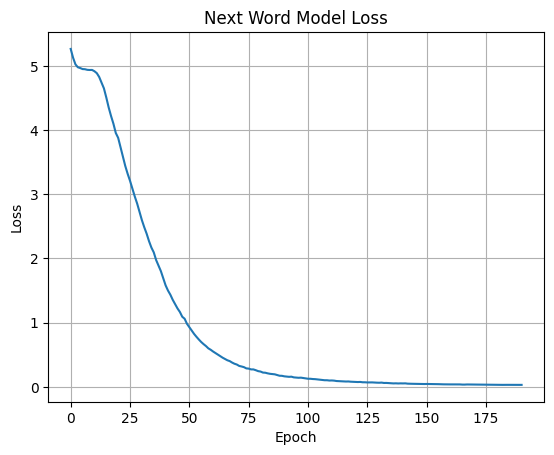

In [47]:
# ------------------------------
# LOAD AND PREPROCESS DATA
# ------------------------------
with open('/content/large_next_word_generation_corpus.txt', 'r') as file:
    generation_data = file.read().lower()

# Use regex to split into sentences (avoid nltk issues)
sentences = re.split(r'(?<=[.!?]) +', generation_data)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

# Tokenizer fit on sentences
gen_tokenizer = Tokenizer()
gen_tokenizer.fit_on_texts(sentences)
total_words = len(gen_tokenizer.word_index) + 1

# Create input sequences of increasing length for next word prediction
input_sequences = []
for line in sentences:
    tokens = gen_tokenizer.texts_to_sequences([line])[0]
    if len(tokens) > 1:
        for i in range(1, len(tokens)):
            input_sequences.append(tokens[:i+1])

max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

X_gen = input_sequences[:, :-1]
y_gen = input_sequences[:, -1]

# ------------------------------
# DEFINE MODEL
# ------------------------------
gen_model = Sequential([
    Embedding(total_words, 128, input_length=max_seq_len-1),
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(total_words, activation='softmax')
])

gen_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.002))

# ------------------------------
# CALLBACKS
# ------------------------------
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_next_word_model.h5', save_best_only=True, monitor='loss')

# ------------------------------
# TRAIN MODEL
# ------------------------------
hist_gen = gen_model.fit(
    X_gen, y_gen,
    epochs=200,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)

# ------------------------------
# PLOT LOSS
# ------------------------------
plt.plot(hist_gen.history['loss'])
plt.title('Next Word Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ------------------------------
# PREPARE INDEX TO WORD MAPPING
# ------------------------------
index_word = {v: k for k, v in gen_tokenizer.word_index.items()}
index_word[0] = ''  # padding token

# ------------------------------
# TEXT GENERATION FUNCTION
# ------------------------------
def generate_text(seed_text, next_words, temperature=1.0, top_k=10):
    result = seed_text
    for _ in range(next_words):
        token_list = gen_tokenizer.texts_to_sequences([result])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        preds = gen_model.predict(token_list, verbose=0)[0]
        preds = np.log(preds + 1e-9) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        top_k_idx = np.argsort(preds)[-top_k:]
        top_k_probs = preds[top_k_idx]
        top_k_probs /= top_k_probs.sum()

        predicted_word_idx = np.random.choice(top_k_idx, p=top_k_probs)
        predicted_word = index_word.get(predicted_word_idx, '')
        result += ' ' + predicted_word
    return result.strip()


# Text Generation Using Model

In [48]:
# Example generation
print(generate_text("mathematics is the study of", 20, temperature=0.7))

mathematics is the study of continuous change much like geometry is the study of shapes and their properties of engineering and physics applications applications the


## Experimenting to get more accuracy

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ------------------------------
# LOAD AND PREPROCESS DATA
# ------------------------------

# Load your large text corpus (choose relevant educational content)
with open('/content/robust_next_word_corpus.txt', 'r') as file:
    generation_data = file.read().lower()

# Split text into sentences using regex (simple and avoids nltk dependencies)
sentences = re.split(r'(?<=[.!?]) +', generation_data)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

# Initialize and fit tokenizer on sentences
gen_tokenizer = Tokenizer()
gen_tokenizer.fit_on_texts(sentences)

# Vocabulary size (add 1 for padding token)
total_words = len(gen_tokenizer.word_index) + 1

# Create sequences of increasing length for next word prediction task
input_sequences = []
for line in sentences:
    tokens = gen_tokenizer.texts_to_sequences([line])[0]
    if len(tokens) > 1:
        for i in range(1, len(tokens)):
            input_sequences.append(tokens[:i+1])

# Find maximum sequence length to pad sequences uniformly
max_seq_len = max(len(seq) for seq in input_sequences)

# Pad sequences (pre-padding)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Split sequences into input (X) and label (y)
X_gen = input_sequences[:, :-1]  # all tokens except last
y_gen = input_sequences[:, -1]   # last token is the next word to predict

# ------------------------------
# DEFINE NEXT WORD GENERATION MODEL
# ------------------------------

gen_model = Sequential([
    Embedding(total_words, 128, input_length=max_seq_len-1),       # Embedding layer
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), # First LSTM layer
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),                 # Second LSTM layer
    Dense(total_words, activation='softmax')                       # Output layer for next word probabilities
])

gen_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.002))

# ------------------------------
# CALLBACKS FOR TRAINING STABILITY
# ------------------------------

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_next_word_model.h5', save_best_only=True, monitor='loss')

# ------------------------------
# TRAIN MODEL
# ------------------------------

hist_gen = gen_model.fit(
    X_gen, y_gen,
    epochs=200,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)

# ------------------------------
# PLOT TRAINING LOSS
# ------------------------------

plt.plot(hist_gen.history['loss'])
plt.title('Next Word Generation Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# ------------------------------
# PREPARE INDEX TO WORD MAPPING
# ------------------------------

index_word = {v: k for k, v in gen_tokenizer.word_index.items()}
index_word[0] = ''  # padding token

# ------------------------------
# TEXT GENERATION FUNCTION
# ------------------------------

def generate_text(seed_text, next_words, temperature=1.0, top_k=10):
    """
    Generate the next words given a seed text using the trained next word prediction model.

    Args:
        seed_text (str): Input text seed (minimum 10 words as per assignment).
        next_words (int): Number of words to generate.
        temperature (float): Controls randomness in sampling; lower is less random.
        top_k (int): Limits sampling to top_k probable next words for diversity.

    Returns:
        str: Generated text including the seed and predicted next words.
    """

    # Enforce seed text length requirement (minimum 10 words)
    if len(seed_text.split()) < 10:
        raise ValueError("Seed text must contain at least 10 words as per assignment requirements.")

    result = seed_text

    for _ in range(next_words):
        # Tokenize current text and pad it to model's input length
        token_list = gen_tokenizer.texts_to_sequences([result])[0]
        token_list = token_list[-(max_seq_len - 1):]  # Truncate to max allowed length if longer
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')

        # Predict next word probabilities
        preds = gen_model.predict(token_list, verbose=0)[0]

        # Apply temperature to control randomness
        preds = np.log(preds + 1e-9) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Restrict to top_k words for sampling diversity
        top_k_idx = np.argsort(preds)[-top_k:]
        top_k_probs = preds[top_k_idx]
        top_k_probs /= top_k_probs.sum()

        # Randomly sample next word index from top_k candidates
        predicted_word_idx = np.random.choice(top_k_idx, p=top_k_probs)
        predicted_word = index_word.get(predicted_word_idx, '')

        # Append predicted word to the result text
        result += ' ' + predicted_word

    return result.strip()

# ------------------------------
# EXAMPLE USAGE
# ------------------------------

seed = "mathematics is the study of quantities and structures that arise from numbers"
try:
    generated_text = generate_text(seed, next_words=20, temperature=0.7, top_k=10)
    print("Generated Text:\n", generated_text)
except ValueError as e:
    print(e)
